In [1573]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Task 1: Data Loading and Initial Exploration

In [1574]:
# loading the dataset
file_path = "titanic3.xls"
df = pd.read_excel(file_path)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Before preprocessing and feature engineering, we must understand the dataset to identify inconsistencies before modeling as well as revealing patterns/distributions helpful for preprocessing decisions.

1. Checking Dataset Structure 
Firstly, I began by checking some basic information such as the shape of the dataset as well as the column names, to check the number of rows we have and columns (features), and to gain a general overview of what data we have to analyze. 

2. Identifying Missing Values
Missing data can affect the model's accuracy, so it is very important to assess which features have missing values. After observation, I noticed: 
- age is missing for 263 passengers 
- fare is missing for 1 passengers 
- cabin is missing for 1014 passengers
- embarked is missing for 2 passengers 
- boat is missing for 823 passengers 
- body is missing for 1188 passengers 
- home.dest is missing for 564 passengers 
We can see that cabin, boat, and body have an extremely high number of missing values, which might make them not useful.
Home.dest also has lots of missing values, though fewer than the others.
Age, fare, and embarked have much fewer missing values, which means they could still be useful with appropriate handling.

3. Summary Statistics Observations
After checking the missing values, .describe() and .info() are used to view summary statistics about the dataset. Some key observations include:
Age:
- a minimum age of 0.17 years (babies) 
- a maximum age of 80 years. 
Fare:
- Some passengers paid $0, which could be an error or maybe a special case. 
Pclass:
- Most passengers were in 3rd class, which confirms a class imbalance.
Additionally, I was able to view the different datatypes of the features in my dataset using .info(), as well as confirm which features contain missing values, allowing me to fully understand my data before working with it.

In [1575]:
# basic info about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns)

# check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# summary statistics
df.info()
df.describe()

Dataset Shape: (1309, 14)

Column Names:
 Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

Missing Values:
 pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


Visualizing data helps in understanding missing values, identifying patterns based on features such as gender, class, and age, and spotting imbalances that might affect model predictions.

1. Heatmap of Missing Values
Although I quantitatively observed missing values  earlier, a heatmap provides a visual aid for recognizing missing data across the different columns and helps determine if a column is too incomplete to be useful. 
- Cabin, boat, and body have too many missing values, making them hard to work with.
- Age and embarked have less missing values, meaning they might still be useful for prediciton.

2. Survival by Gender
This visualization helps check whether gender impacted survival rates.
- The countplot shows that more men died compared to women (possibly due to the women and children first rule).
From this, we can infer gender is going to be an important feature for predicting survival.

3. Survival by Passenger Class
This allows us to check if ticket class could have affected chance of survival.
- 1st class passengers had higher survival rates
- 3rd class passengers had the highest death rate 
This suggets that the wealthier passengers had better access to lifeboats, and we can therefore infer that class is related to survival and that we should include it in our model.

4. Age Distribution of Survivors vs Non-survivors
This allows us to see if age could have affected survival rates.
- Children had higher survival rates (again, women and children first rule).
- Elderly passengers had lower survival rates, possibly due to physical limitations in evacuations.
- Adults (20-40) had more non-survivors than survivors, but survival was still present across the group. 
Since survival varies across different age ranges, categorizing passengers into age groups may improve model performance compared to using raw age values.

Summary of insights gathered:
- Columns with too many missing values may be dropped, while others imputed.
- Gender, class, and age are all likely important factors.
- Age could benefit from categorization into groups.

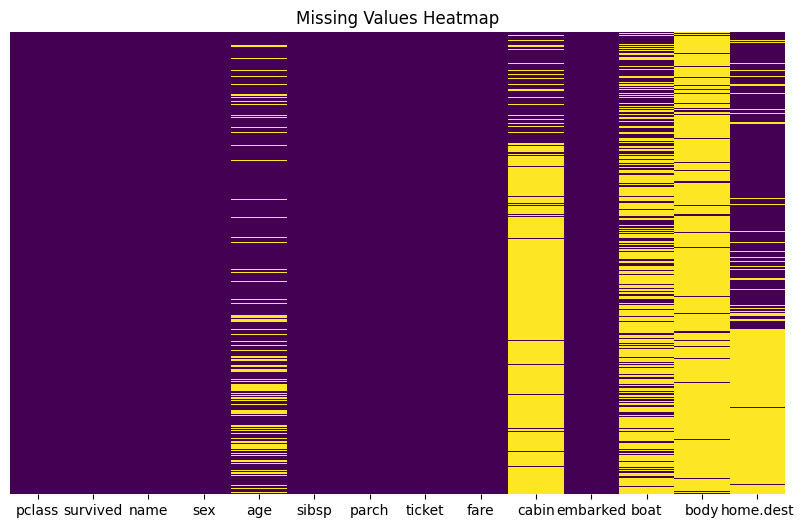

In [1576]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

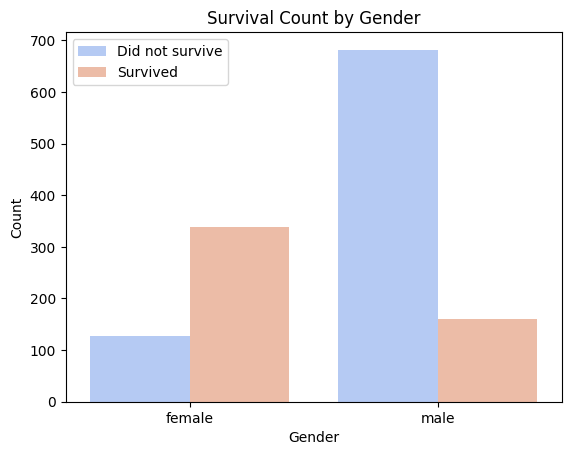

In [1577]:
sns.countplot(data=df, x='sex', hue='survived', palette='coolwarm')
plt.title("Survival Count by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(["Did not survive", "Survived"])
plt.show()

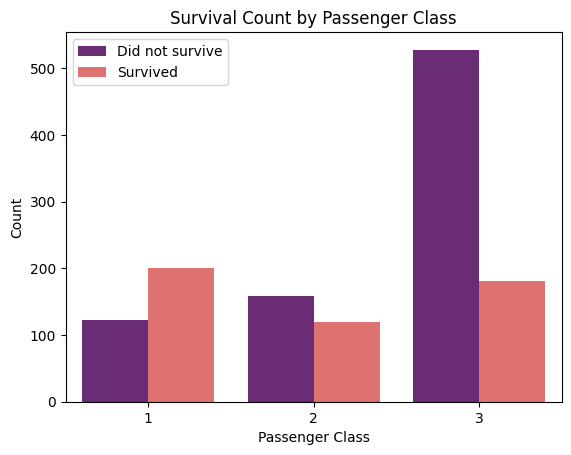

In [1578]:
sns.countplot(data=df, x='pclass', hue='survived', palette='magma')
plt.title("Survival Count by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Count")
plt.legend(["Did not survive", "Survived"])
plt.show()

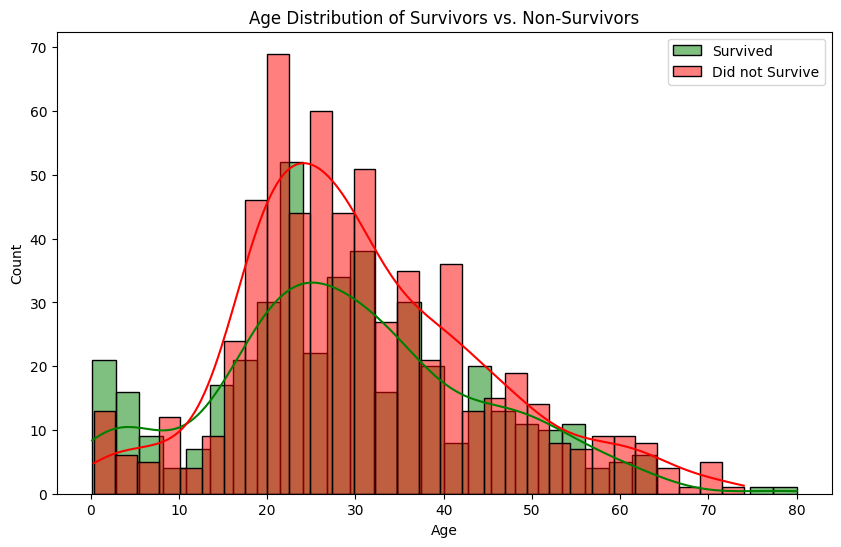

In [1579]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df['survived'] == 1]['age'], bins=30, kde=True, color="green", label="Survived")
sns.histplot(df[df['survived'] == 0]['age'], bins=30, kde=True, color="red", label="Did not Survive")
plt.legend()
plt.title("Age Distribution of Survivors vs. Non-Survivors")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

Another visualization method I thought to use was to compare survival rates by different features I considered relevant to survival, and see if there is any correlation or meaningful insights to be found.

1. Sex and survival
I first began by checking sex, as it is very likely that the "women and children first" rule was followed. If this policy influenced survival rates, we would expect females to have a higher survival rate than men. The barplot confirmed this, with around 70% of females surviving but only 20% of males surviving. From this, I can assume that gender impacted survival chances.

2. Pclass and survival
Then, I checked the passenger class, since higher class passengers were physically closer to the safety exits and had better accomodations in general, meaning more access to lifeboats. If class did affect survival, the first class passengers would have the highest survival rate, then second then third. The barplot confirmed this pattern and asserted that richer passengers had better survival chances.

3. Embarked location and survival
Since the passengers boarded from different locations, I was curious to see if where they embarked affected their survival rate. I believed this would be insightful as it is known that passengers embarking from port C had more first class passengers, meaning that embarkation location might've indirectly affected survival. The barplot confirmed that port C had the highest survival rate, implying many first class passengers, whilst port S and port Q had similar survival rates, implying a mix of passenger classes.


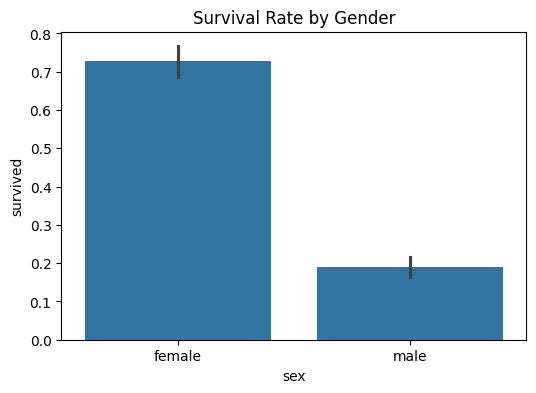

In [1580]:
# survival Rate by sex
plt.figure(figsize=(6,4))
sns.barplot(x="sex", y=df["survived"], data=df)
plt.title("Survival Rate by Gender")
plt.show()

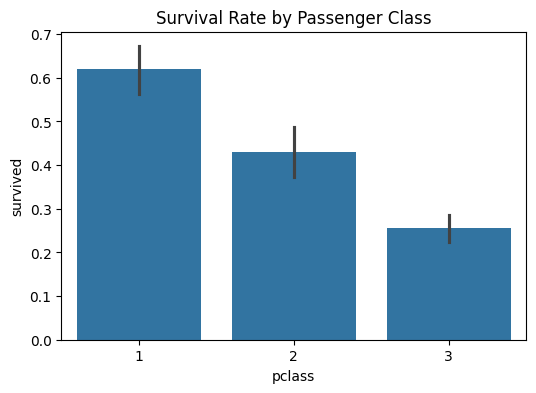

In [1581]:
# survival rate by passenger class
plt.figure(figsize=(6,4))
sns.barplot(x="pclass", y=df["survived"], data=df)
plt.title("Survival Rate by Passenger Class")
plt.show()

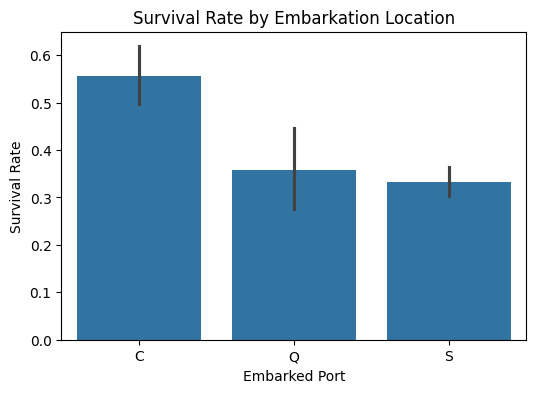

In [1582]:
# survival rate by embarked location
plt.figure(figsize=(6, 4))
sns.barplot(x="embarked", y=df["survived"], data=df, order=["C", "Q", "S"])
plt.title("Survival Rate by Embarkation Location")
plt.ylabel("Survival Rate")
plt.xlabel("Embarked Port")
plt.show()

Finally, I felt it was important to analyze the distributions of my data, specfically the numerical features. Understanding these distributions would help with identifying any skewness, outliers, or scaling issues that might impact the model. This will also be helpful later when deciding which scaling techniques are needed, if any.
Instead of automatically selecting numerical features using select_dtypes(), I manually selected them based on dataset knowledge. I preferred this method because sometimes, some columns (for example pclass) are classified as numerical due to their integer values, but are actually categorical. I selected age, sibsp, parch, and fare for numerical features.

The results showed that age is slightly right skewed, with most passengers being between 20-40 years old. Both sibsp and parch is highly skewed towards 0, so most passengers traveled alone. Fare is heavily skewed as well, implying some passengers paid very high fares, indicating potential outliers. 
These interpretations will be useful later when determining which transformations might be necessary, such as scaling/normalization.

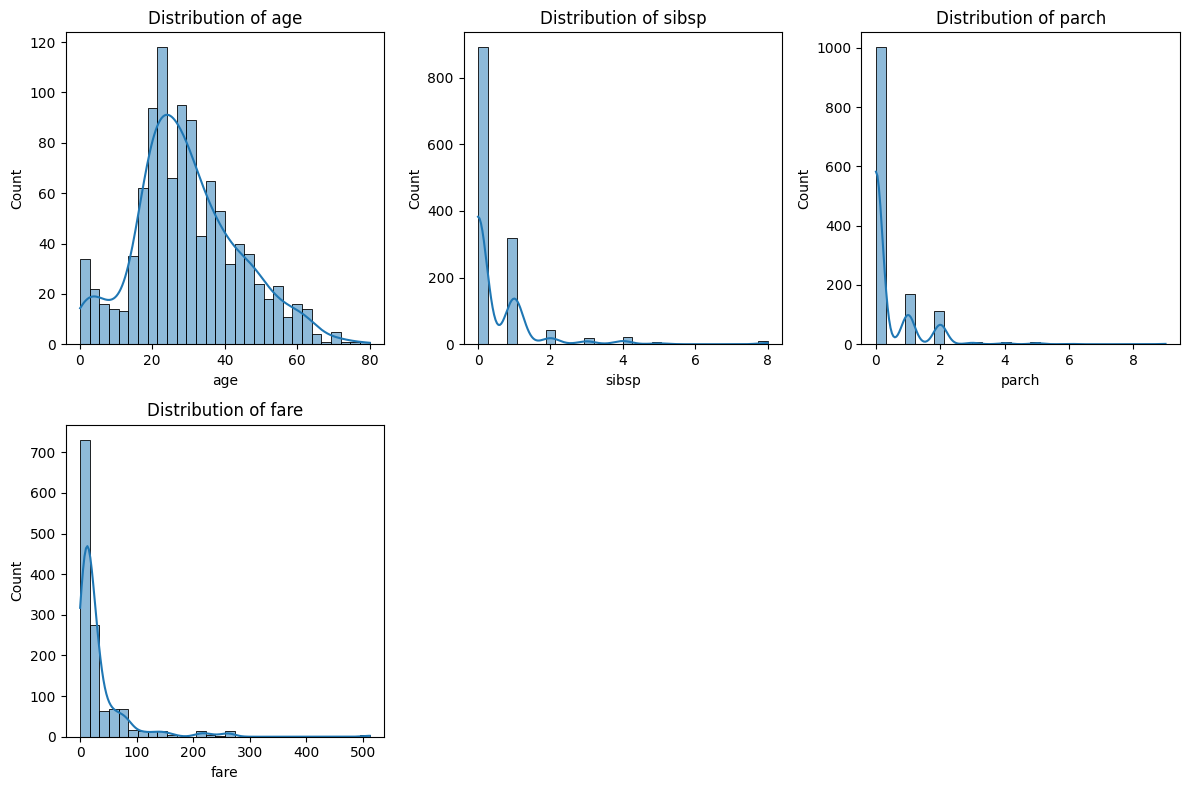

In [1583]:
# numerical features
numerical_features = ["age", "sibsp", "parch", "fare"]

# plot distributions
plt.figure(figsize=(12, 8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

Since extreme values in numerical features can mess up the model's predictions, I decided to do a formal outlier check on my features. Outliers can affect the model in many different ways. Some could be errors or rare causes that we should handle by alone, while others could have some meaningful insights. Checking them early on helps with deciding if we should remove, transform, or keep them later for preprocessing.
Using boxplots to identify potential outliers, I discovered that::
- Age had a few outliers above 70, but they are still reasonable values, and just represent elderly passengers
- Sibsp and parch both have some extreme values, suggesting most passengers traveled by themslves, or that some traveled as a large family.
- Fare had many extreme outliers, with some of the fares being even more than 500. This indicates ticket prices were very varied, probably due to class differences.

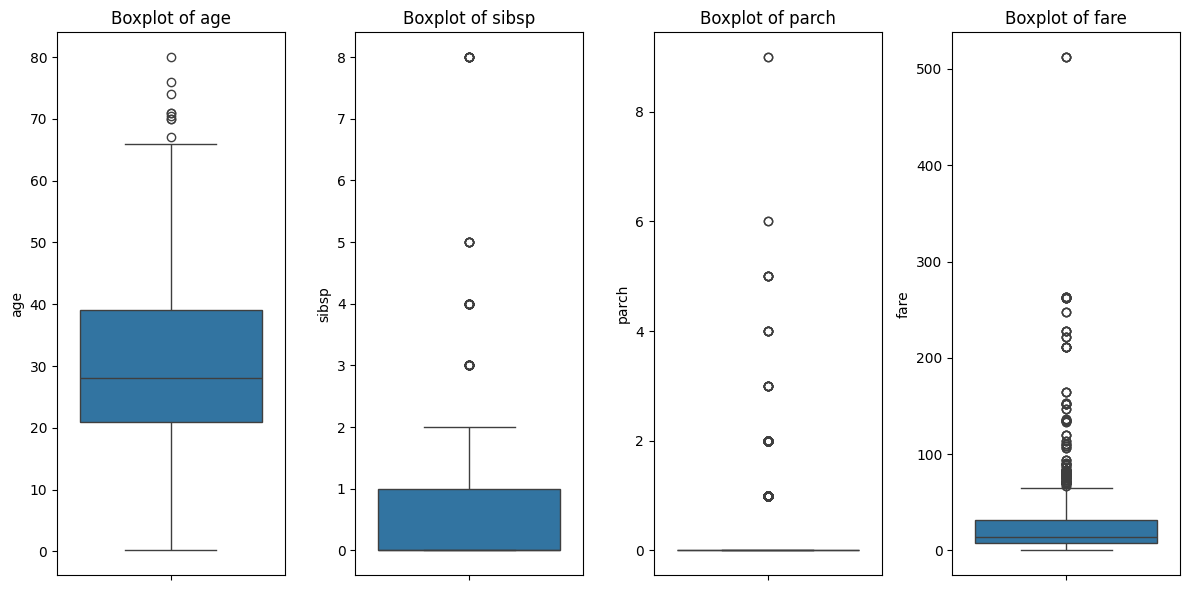

In [1584]:
# features to check for outliers
outlier_features = ["age", "sibsp", "parch", "fare"]

plt.figure(figsize=(12, 6))

# create boxplots for each feature
for i, feature in enumerate(outlier_features, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(y=df[feature])
    plt.title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

Finally, the last EDA step I thought to perform was correlation analysis between the numerical features. Upon research, I came to understand that correlation analysis can help identify relationships and provide insights about how they interact. It can also provide important insights when it comes to feature selection, as if two features are highly correlated, one might be redundant and we can remove it and effectively reduce dimensionaltiy. This will be very useful later, during feature selection. 

I initially considered alternatives but eventually decided to go with a heatmap for two main reasons:
1. It is color coded, making it easy to spot strong/weak correlations. This makes it more convenient than using raw correlation tables.
2. It allows to compare mutliple features at once, rather than checking individual pairwise scatterplots.

The results showed:
- Sibsp and parch had the highest correlation (0.37). This made sense since if a passenger was traveling with siblings/spouses they were probably also traveling with parents/children.
- Age had weak negative correlations with sibsp (-0.24) and parch (-0.15), which implies younger passengers were more likely to travel with family.
- Fare had relatively low correlation with all of the other features, so it might behave independently.
- No features showed extremely high correlations (>0.8), so it is difficult to deduce any obvious redundancies.

This analysis would normally provide more direct/obvious insights when it comes to feature selection, however in this case it seems there are no features that clearly need removal due to high correlation. Nevertheless, sibsp and parch have the highest correlation, so I will keep this in mind during feature selection later.

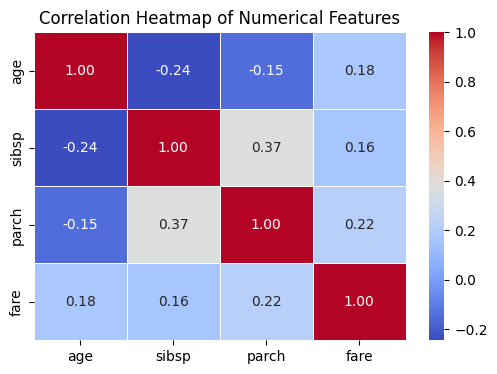

In [1585]:
# numeric columns
numerical_features = ["age", "sibsp", "parch", "fare"]

# correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# Task 2: Managing missing values (dropping)

When managing missing values, I first checked for missing data in the entire dataset before splitting, to decide which columns to drop. Dropping columns should be done before splitting, as this prevents inconsistencies. However, imputation should be done after splitting, as doing it before would lead to data leakage since the imputation strategy would be based on the entire dataset, including the test and validation sets (which the model should not see when being trained). 

To fully understand the missing data, I began by printing missing values in the dataset. To decide whether to drop or impute missing values, I used a common rule of thumb widely used for smaller projects:
- If a column had more than 30% missing values, it was deemed unhelpful and was therefore dropped.
- If a column had less than 30% missing values, it was imputed instead.

After analyzing the missing data, we can see that cabin (77.46%), boat (62.87%), body (90.76%) and home.dest (43.08%) are all greater than the 30% missing value threshold. Hence, these columns are dropped from all three sets, as there is too much missing data for these columns to be of any use.

In [1586]:
# Check missing values in the entire dataset BEFORE splitting
print("Missing values in Dataset:\n", df.isnull().sum())

Missing values in Dataset:
 pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64


In [1587]:
# Calculate missing percentages
missing_percent = (df.isnull().sum() / len(df)) * 100
print("\nMissing Value Percentages:\n", missing_percent)


Missing Value Percentages:
 pclass        0.000000
survived      0.000000
name          0.000000
sex           0.000000
age          20.091673
sibsp         0.000000
parch         0.000000
ticket        0.000000
fare          0.076394
cabin        77.463713
embarked      0.152788
boat         62.872422
body         90.756303
home.dest    43.086325
dtype: float64


In [1588]:
# Drop columns with excessive missing values BEFORE splitting
cols_to_drop = ["cabin", "boat", "body", "home.dest"]
df.drop(columns=cols_to_drop, inplace=True)

# Task 3: Data Splitting

Although data splitting is task 5 in the instructions, after careful review, I have decided to move task 5 here to prevent data leakage. There are two main reasons for my choice:

1. Imputting missing values before splitting means computed values (such as median) would be based on the entire dataset, which would include the test and validation sets. This allows data that the model will be tested/validated on later to influence training data, which would lead to overly good results.


2. If we scale features before splitting, the mean and standard deviation are computed from the entire dataset, which means that test data would influence how the training data is transformed, leading to data leakage. 

The dataset was divided into training (80%), validation (10%), and test (10%) sets. Stratification was used on survived, so that the percentage of survivors is consistent across all splits. Without stratification, there might be too many survivors randomly assigned to one set and too little to another, which would lead to unreliable model training.

1. First split (80% training, 20% others):
- The training set should be the largest portion, since it is used to train the model. Since the titanic dataset is considered relatively small, the model would benefit off of a larger training set.
- Random state is set to 42, for reproducibility

2. Second split (10% validation, 10% test):
- The validation set is used to tune hyperparameters and prevent overfitting. We can evaluate the model during training.
- The test set allows for an unbiased evaluation of the model performance. It is only used once, after all training is complete. It is meant to simulate real world performance.

The decision of 80 10 10 is based on:
1. Dataset size. The titanic dataset is small, which means we must maximize the amount of data available for training.
2. A general rule of thumb, for small to medium sized datasets

In [1589]:
# defining the target variable
y = df["survived"]  # target column to predict
X = df.drop(columns=["survived"])  # features we use to make predictions

# first split: training (80%) and others (20%)
X_train, X_other, y_train, y_other = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# second split: validation (10%) and test (10%) from 'others'
X_val, X_test, y_val, y_test = train_test_split(
    X_other, y_other, test_size=0.5, stratify=y_other, random_state=42
)

# confirming the shape of the splits
print("Training Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)


Training Set: (1047, 9) (1047,)
Validation Set: (131, 9) (131,)
Test Set: (131, 9) (131,)


# Task 3: Managing Missing Values

When managing missing values, I used only the training set to make decisions about handling missing values, in aim of preventing data leakage.
My reasoning behind this comes from the actual purpose of the validation and test sets. Their purpose is to evaluate the model, not to influence any preprocessing decisions. The test set and validation set should stay unseen by the model during preprocessing decisions, otherwise the model would indirectly learn from them and cause a data leakage. 
Hence, I checked missing values only in X_train, since it is the main dataset for learning patterns. All transformations are first applied to X_train and then  applied to X_test and X_val to ensure consistency.

We can see that age (19.39%), fare (0.10%), and embarked (0.19%) are less than the 30% threshold discussed in task 2, hence we can use imputation instead. Since age is numerical it is imputed with the median to handle outliers. Fare is also numerical and only has a tiny fraction of missing values, so it is also imputed with the median. Embarked is categorical, hence it is imputed with the mode.

There are multiple ways to handle missing values. The first one that came to mind and that felt the most intuitive was to manually compute the median and fill in missing values using .fillna(). However, upon further research, I decided to use SimpleImputer for 3 main reasons:
1. Efficiency, as the process is automated and less repetitive.
2. Consistency, as it ensures the same imptuation method is applied across multiple columns at once.
3. Scalability, as if I had to apply imputation to more features, SimpleImputer would make the code more compact.

For the imputation strategy, I used the median for the numerical features (age, fare) instead of the mean since it is more resistant to outliers. For embarked, the mode was used since it is categorical. Since SimpleImputer outputs a NumPy array, .ravel() was used to convert it into a 1D array before assigning it back to the DataFrame, ensuring embarked stays categorical. 
Although I could have created separate imputers for age and fare, both features use the same imputation strategy (median). To keep the code more efficient and maintainable, I decided to use a single imputer for all numerical features. Since embarked is categorical and requires mode imputation, it needed a separate imputer. 
During imputation, it is important to fit only on the training set and then apply that transformation to the test set and validation set. The reason for this is to prevent data leakage:
- Applying fit() to only the training set means the median is calculated using only the training data. 
- If we use fit() on the test/validation sets, then the model would indirectly learn from them, causing false high model performance. 

After fitting, transform() is used on all 3 sets to fill in the missing data using the same median computed from the training set. For the training set, fit_transform() was used instead of fit() then transform() separately, for efficiency and code readability. By following this approach, we effectively ensured that the test and validation sets stay untouched during training, allowing our results to be realistic and reliable.

In [1590]:
# create imputers for each feature and choose strategy
num_imputer = SimpleImputer(strategy="median")  # for numerical features
cat_imputer = SimpleImputer(strategy="most_frequent")  # for categorical features

# fit & transform the TRAINING set
X_train[["age", "fare"]] = num_imputer.fit_transform(X_train[["age", "fare"]])
X_train["embarked"] = cat_imputer.fit_transform(X_train[["embarked"]]).ravel()

# apply the same transformation to validation and test sets (transform only, NO FITTING again)
X_val[["age", "fare"]] = num_imputer.transform(X_val[["age", "fare"]])
X_val["embarked"] = cat_imputer.transform(X_val[["embarked"]]).ravel()

X_test[["age", "fare"]] = num_imputer.transform(X_test[["age", "fare"]])
X_test["embarked"] = cat_imputer.transform(X_test[["embarked"]]).ravel()

Finally, after handling the missing data, I confirmed that there are no more missing values in any of the sets before moving on.

In [1591]:
# check missing values in each set after handling missing data, to confirm no missing values
print("Missing values in Training Set:\n", X_train.isnull().sum())
print("\nMissing values in Validation Set:\n", X_val.isnull().sum())
print("\nMissing values in Test Set:\n", X_test.isnull().sum())

Missing values in Training Set:
 pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
ticket      0
fare        0
embarked    0
dtype: int64

Missing values in Validation Set:
 pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
ticket      0
fare        0
embarked    0
dtype: int64

Missing values in Test Set:
 pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
ticket      0
fare        0
embarked    0
dtype: int64


# Task 4: Creating new features

Before moving on to encoding (yet still after splitting the dataset to avoid data leakage), I began to think of key features not already included in the dataset that could improve model performance. This is part of feature engineering, the creation of new features. Feature engineering is important to extract even more meaningful information from existing data, rather than limiting ourselves to columns already in the dataset. 

1. Family Size
I thought to include this feature since larger families might struggle to get everyone on lifeboats, giving smaller families a better chance of escape. To check this I derived a family size variable, which came from adding num of siblings and parents/children of a passenger.

2. Title
I thought to extract the title from passenger name since the name column itself is not very useful, but can be manipulated to contain useful information. Whilst a passenger's name tells us nothing, their title may provide insights into their gender and social status. I extracted the title using regex.

Initially I thought to add a feature that indicated whether or not a passenger had a cabin, as this would imply wealthier passengers, however there was too much missing data from this column. I also considered grouping fare and age into bins, but in the end decided not to as I felt keeping them continuous would perserve more information.

The code for creating the family size feature involved adding the num of siblings/spouses and parents/children, then adding 1, to include the passenger themselves. 
To extract the title, I used regex. Since some titles were rare, I realized I might run into some issues later on during encoding, if there are unknown categories in validation/test sets. So, I grouped these rare titles into their own category Rare.

In [1592]:
# create family size feature
X_train["family_size"] = X_train["sibsp"] + X_train["parch"] + 1
X_val["family_size"] = X_val["sibsp"] + X_val["parch"] + 1
X_test["family_size"] = X_test["sibsp"] + X_test["parch"] + 1

In [1593]:
# get passenger titles from their name (using raw string `r""` to avoid escape sequence issue)
X_train["title"] = X_train["name"].str.extract(r" ([A-Za-z]+)\.")
X_val["title"] = X_val["name"].str.extract(r" ([A-Za-z]+)\.")
X_test["title"] = X_test["name"].str.extract(r" ([A-Za-z]+)\.")

# group rare titles to avoid unknown titles in validation/test sets
common_titles = ["Mr", "Mrs", "Miss", "Master"]
X_train["title"] = X_train["title"].apply(lambda x: x if x in common_titles else "Rare")
X_val["title"] = X_val["title"].apply(lambda x: x if x in common_titles else "Rare")
X_test["title"] = X_test["title"].apply(lambda x: x if x in common_titles else "Rare")

To gain some general knowledge about these features, I created barplots comparing them with survival rates. The insights gained include:
- The survival rate does indeed vary with family size. Passengers traveling alone had low survival rates, smaller families had the highest, then larger families experienced a huge drop in survival chances. This works with my initial assumption that smaller families are able to escape better.
- Mrs and Miss had the highest survival rate which supports the women and children first rule. Mr had the lowest, confirming that adult men had the least likely chance of surviving. Rare titles fell somewhere in between, possibly due to mixed social status. This provided insights into gender and even social status.

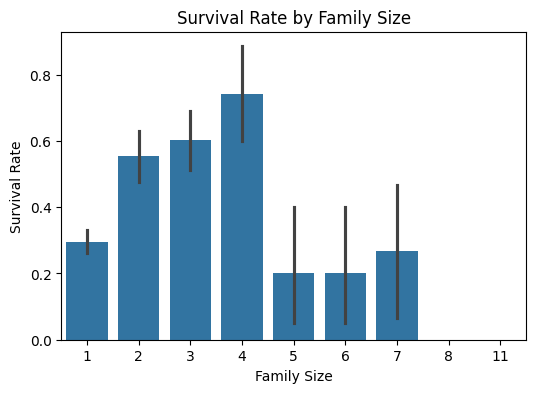

In [1594]:
plt.figure(figsize=(6,4))
sns.barplot(x="family_size", y=y_train, data=X_train)  # Use X_train, not df
plt.title("Survival Rate by Family Size")
plt.xlabel("Family Size")
plt.ylabel("Survival Rate")
plt.show()

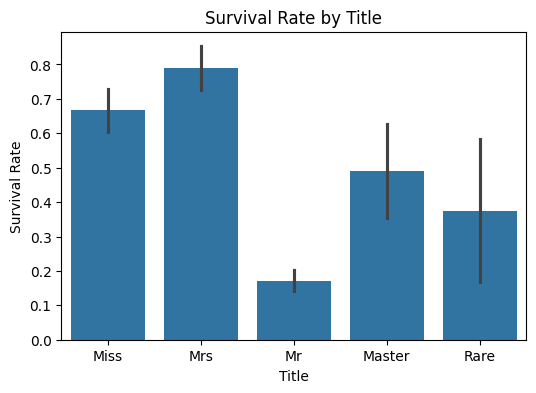

In [1595]:
plt.figure(figsize=(6,4))
sns.barplot(x="title", y=y_train, data=X_train)  # Use X_train, not df
plt.title("Survival Rate by Title")
plt.xlabel("Title")
plt.ylabel("Survival Rate")
plt.show()

# Task 5: Encoding Categorical Variables

Originally, I tried to find the categorical variables using code, by selecting all the object type columns. However, that lead to incorrect results, including irrelevant categories such as name. So instead, I manually selected sex and embarked as categorical features based on dataset knowledge. Pclass was treated as an ordinal categorical variable, since it is hierarchical. 

Encoding categorical variables can be done before or after splitting, but I decided to encode after splitting mainly to avoid data leakage. If we encode then split, info from the test/validation sets would influence training, and then the model would indirectly learn from data it was not supposed to see.

If encoding is done before splitting, we would avoid the issue of a category that was not in the training set appears in the validation/test sets, it would cause an error. However there is a way to handle this, which is setting the parameter handle_unknown = "ignore"

Encoding could also be done before splitting, but is usually done when the dataset is very small, or if feature hashing is used (since it doesn't require learning from the data)

In [1596]:
categorical_features = ["sex", "embarked"]  # manually selected

print("Categorical Features:", categorical_features)

Categorical Features: ['sex', 'embarked']


After identifying the categorical variables, I used OneHotEncoder to convert them into numerical features. To prevent errors in the case that there is a category in the test/validation sets that was not in the training set, the parameter handle_unknown is set to ignore. The parameter sparse_output is set to false to return a dataframe rather than a sparse matrix. 

Then, we fit the encoder only on the training data (to avoid data leakage), and use the same transformation on the test and validation sets. 

The next step is to merge our newly encoded data with our old dataset, however OneHotEncoder outputs a NumPy array instead of a dataframe. So, we must assign meaningful names to the new columns. At first I thought to manually rename the columns, however this turned out to be tedious and led to unnecessary errors. Upon further research, I decided to use get_feature_names_out, which automatically generates meaningful column names. 

The encoded data was converted into a dataframe with the appropriate column names, and I dropped the old categorical columns. Initially, I considered using .reset_index(drop=True) to drop, but since no rows were removed and pd.concat() aligns data by index automatically, it was unnecessary. The newly encoded data was then merged with the original dataset. I set drop = "first" as a parameter, so that the dropped category becomes a baseline that the remaining categories are compared to. If all categories were included, this might lead to multicollinearity and affect the model in several ways:
1. There would be redundant information. One category could be perfectly predicted from the others, making it unnecessary.
2. This perfect correlation would cause instability in our logistic regression model and make it difficult to interpret the model.
3. It is important to have a reference variable to compare other categories with to make the model more interpretable and make more sense.

Finally, I verified that the dataset shape has changed, increasing from 10 to 14 due to the addition of one-hot encoded features. I also printed a sample of the dataset to confirm the presence of the encoded categorical features.

In [1597]:
encoder1 = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop = "first")

X_train_encoded = encoder1.fit_transform(X_train[categorical_features])
# transform validation & test sets (DO NOT fit again)
X_val_encoded = encoder1.transform(X_val[categorical_features])
X_test_encoded = encoder1.transform(X_test[categorical_features])

Since pclass represents a natural ordering (1st, 2nd, 3rd class), I used ordinal encoding instead of one hot encoding. One hot encoding would lose the ranking relationship, and effectively make the data less meaningful.

In [1598]:
# ordinal encoding to convert titles into numbers
encoder2 = OrdinalEncoder()
X_train["title"] = encoder2.fit_transform(X_train[["title"]])
X_val["title"] = encoder2.transform(X_val[["title"]])
X_test["title"] = encoder2.transform(X_test[["title"]])

In [1599]:
# get new column names for encoded features
encoded_columns = encoder1.get_feature_names_out(categorical_features)
# convert to a dataframe with new column names
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_columns, index=X_train.index)
X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=encoded_columns, index=X_val.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_columns, index=X_test.index)

In [1600]:
# drop original categorical columns
X_train = X_train.drop(columns=categorical_features)
X_val = X_val.drop(columns=categorical_features)
X_test = X_test.drop(columns=categorical_features)

# concatenate encoded features with the rest of the dataset
X_train = pd.concat([X_train, X_train_encoded_df], axis=1)
X_val = pd.concat([X_val, X_val_encoded_df], axis=1)
X_test = pd.concat([X_test, X_test_encoded_df], axis=1)

In [1601]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

print("First few rows of X_train:")
print(X_train.head())

X_train shape: (1047, 12)
X_val shape: (131, 12)
X_test shape: (131, 12)
First few rows of X_train:
      pclass                                           name   age  sibsp  \
999        3              McCarthy, Miss. Catherine "Katie"  28.0      0   
392        2  del Carlo, Mrs. Sebastiano (Argenia Genovesi)  24.0      1   
628        3              Andersson, Miss. Sigrid Elisabeth  11.0      4   
1165       3                               Saad, Mr. Khalil  25.0      0   
604        3                    Abelseth, Miss. Karen Marie  16.0      0   

      parch         ticket     fare  family_size  title  sex_male  embarked_Q  \
999       0         383123   7.7500            1    1.0       0.0         1.0   
392       0  SC/PARIS 2167  27.7208            2    3.0       0.0         0.0   
628       2         347082  31.2750            7    1.0       0.0         0.0   
1165      0           2672   7.2250            1    2.0       1.0         0.0   
604       0         348125   7.6500   

One-hot encoding has a significant impact on machine learning models, as it transforms categorical data into a numerical format that models can process. Without encoding, categorical variables might be misinterpreted as having a ranking/ordering, which can distort model predictions. One-hot encoding fixes this issue by creating separate binary features for each category. This allows models to handle categorical variables without assuming any implicit ordering or relationships. Linear models in particular benefit from one-hot encoding. 

Although it improves predictive performance and prevents categorical misinterpretation, it does have some downsides as well. It increases dataset dimensionality and the number of features in the dataset. Since there are more features, training times are also longer for certain algorithms, so feature selection might be necessary if encoding leads to too many extra features.

Other encoding methods include BoW and TF-IDF, however they were not suited to this dataset as it does not have free-text features. If they were used, they should be done after splitting to prevent data leakage. Target encoding was not used here as one hot encoding was preferred, but if it was it should also be applied only after splitting. Feature hashing was not necessary either, but it could be done before or after splitting, however hash collisions could impact performance.

# Task 6: Feature Scaling

Before applying feature scaling, I needed to first decide whether to normalize or standardize my numerical features. During the first task (EDA), I had already found that my numerical features were age, sibsp, parch, fare. Since the dataset was split, I checked the distributions again, this time in the training set, to ensure consistency and avoid data leakage. Then, I assessed the distribution of all these features, which initially guided my decisions on whether I should normalize or standardize.

Although not a fixed rule, a general (weak) rule of thumb is that standardization works better for normally distributed data, whereas normalization is better otherwise. Sibsp, parch, and fare were all heavily right skewed distributions. However, age, although still skewed to the right, had only a slight skew. Hence I decided to conduct some normalization tests I had learned from last years fundamentals of data analysis course. 

The results of all 3 tests confirmed that age did not follow a normal distribution, with the p value of both the Shapiro-Wilk and Kolmogorow-Smirnov tests being smaller than 0.05 (hence we reject the null hypothesis that age follows a normal distribution), as well as the Q-Q plot with data points deviating from the red line at the tails.

Hence, my initial conclusion was that all features should be normalized using MinMaxScaler. This decision was based on the assumption that standardization is not the preferred option since the data does not follow a normal distribution.

However, upon revisiting my approach, I remembered that the final model is a logistic regression model. Upon research, I found that logistic regression works best with standardized data, since it uses weights that can be disproportionately affected by features with large magnitude differences. Since the rule of thumb I mentioned earlier is weak anyways and not always reliable, I came to the final decision to standardize all numerical features instead of normalizing them. I initially thought to do a log transformation to fare, to make it more normal before standardizing since it is so heavily skewed, however I decided against it since logistic regression doesn't require features to be normally distributed and the extreme values in fare could actually contain useful information for predicting survival. So, I decided to keep it simple unless there's a clear benefit and if the model is performing poorly, I could experiment with log-transforming in the future.

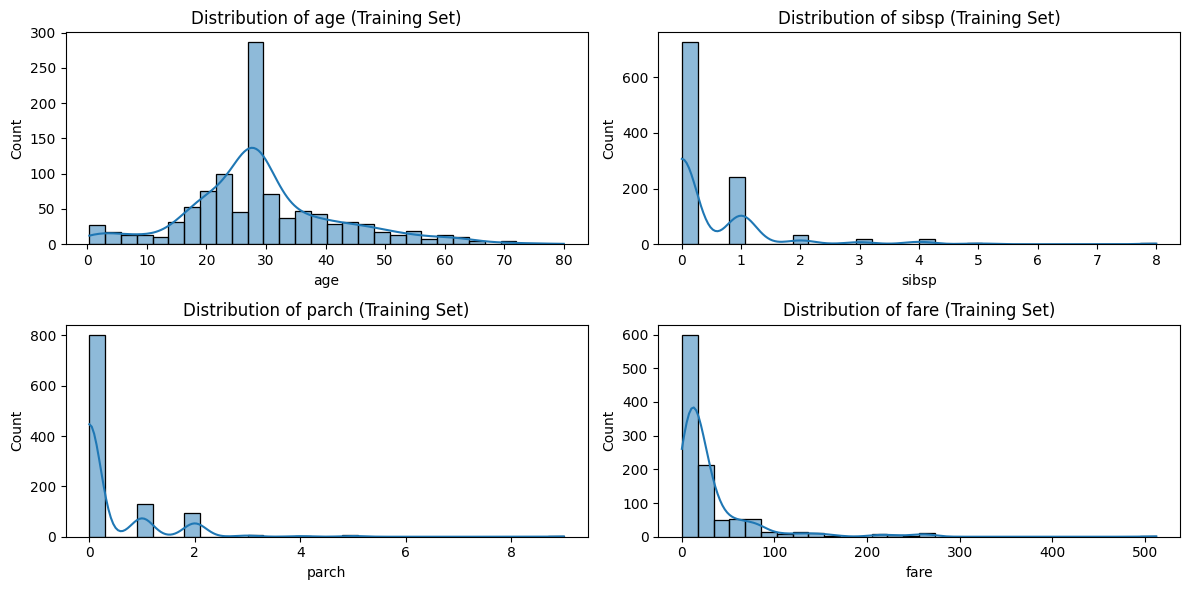

In [1602]:
# numerical features
numerical_features = ["age", "sibsp", "parch", "fare"]

# plot distributions for X_train
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(X_train[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature} (Training Set)")
plt.tight_layout()
plt.show()


Shapiro-Wilk Test: p-value = 4.478852701313212e-18
Kolmogorov-Smirnov Test: p-value = 1.718467426779691e-23


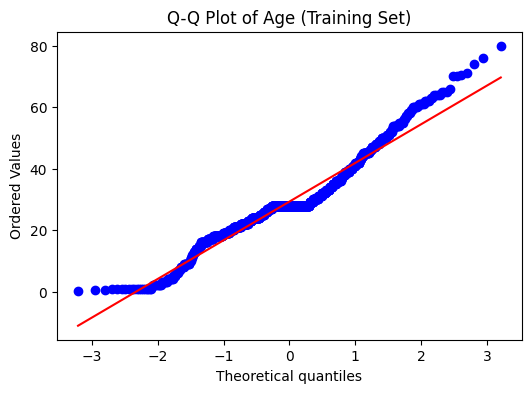

In [1603]:
# shapiro-wilk test (for normality)
shapiro_test = stats.shapiro(X_train["age"])  
print(f"Shapiro-Wilk Test: p-value = {shapiro_test.pvalue}")

# kolmogorov-smirnov test (for normality)
ks_test = stats.kstest(X_train["age"], "norm", args=(X_train["age"].mean(), X_train["age"].std()))
print(f"Kolmogorov-Smirnov Test: p-value = {ks_test.pvalue}")

# Q-Q plot to visually check normality
fig, ax = plt.subplots(figsize=(6, 4))
stats.probplot(X_train["age"], dist="norm", plot=ax)
plt.title("Q-Q Plot of Age (Training Set)")
plt.show()

In [1604]:
# numerical features
numerical_features = ["age", "sibsp", "parch", "fare"]

# initialize StandardScaler
scaler = StandardScaler()

# fit on training data ONLY and transform all sets
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# verify transformation
print("First few rows of standardized X_train:")
print(X_train.head())

First few rows of standardized X_train:
      pclass                                           name       age  \
999        3              McCarthy, Miss. Catherine "Katie" -0.099867   
392        2  del Carlo, Mrs. Sebastiano (Argenia Genovesi) -0.410961   
628        3              Andersson, Miss. Sigrid Elisabeth -1.422019   
1165       3                               Saad, Mr. Khalil -0.333188   
604        3                    Abelseth, Miss. Karen Marie -1.033151   

         sibsp     parch         ticket      fare  family_size  title  \
999  -0.479571 -0.447597         383123 -0.499246            1    1.0   
392   0.510785 -0.447597  SC/PARIS 2167 -0.090614            2    3.0   
628   3.481854  1.872374         347082 -0.017890            7    1.0   
1165 -0.479571 -0.447597           2672 -0.509988            1    2.0   
604  -0.479571 -0.447597         348125 -0.501292            1    1.0   

      sex_male  embarked_Q  embarked_S  
999        0.0         1.0         0.0  


Standardization and normalization are both common feature scaling techniques, and are crucial tools to ensure that numerical variables contribute equally to a model. However, it is very important to understand their differences before choosing which one to use. Ultimately, the choice between them depends on the dataset at hand, as well as what model we will use.

Standardization:
- Transforms the data to have a mean of 0 and std deviation of 1
- Keeps the original shape of the distribution (just scales it)
- Useful for logistic regression and other models that are affected by magnitude differences
Normalization:
- Rescales data between 0 and 1
- More useful for distance-based algorithms(neural networks, etc)
- Works well when data has no strong outliers

With all these main differences in mind, I opted to use standardization rather than normalization. Regardless, both are very important to make sure that numerical variables are equally contributing to a model, to make sure comparisons are fair across features and effectively improve the model performance.

# Task 7: Addressing Class Imbalance

Before continuing, it is important to address the class imbalance in the dataset, as imbalanced data can lead to models being biased towards the majority class. Standard models normally assume balanced classes, and so this makes them struggle to learn patterns for the minority class, effectively leading to poor generalization.

There are two main approaches for handling this issue:
1. Oversampling, which is adding synthetic examples to the minority class
2. Undersampling, which is removing examples from the majority class. 
I also could have adopted a hybrid approach, and combined oversampling with undersampling. 

Although oversampling techniques were suggested in the instructions, I would have decided to oversample rather than undersample or employ a hybrid technique regardless, for two main reasons I came to understand after studying/researching:
1. Normally, undersampling is used when dealing with MASSIVE datasets, and there isn't enough compute/memory to process the data. It is mainly done to make training of models more manageable when working within a limited compute. The titanic dataset is not excessively huge, so this is not a concern in my case.
2. Unlike undersampling, there is no loss of information in oversampling. Oversampling retains all available data, and so it may lead to better performance.

After deciding on which approach to use, I needed to decide which methods within oversampling to use. Although the two oversampling methods suggested SMOTE and ADASYN both generate data using k-nearest neighbors, they have key differences to take into account. After researching both methods, the differences I came to understand are:
- SMOTE generates samples evenly across all minority class instances.
- ADASYN focuses more on the minority class samples that are harder to classify, and generates more data for those cases.
- If the dataset just needs basic balancing and is only moderately imbalanced, SMOTE is more reliable and the more standard approach.
- If the dataset has a SEVERE class imbalance or has hard to classify cases, ADASYN may work better.

With all this information in mind, I first checked the class distrubution of my variable. The imbalance was not severe, with 400 (38%) surviving and 647 (62%) not survivng. This suggested that SMOTE would be the safer yet still sufficient choice. Adding on to this, the titanic dataset itself has relatively clear class separations (for example women and first class passengers having higher survival rates), so we wouldn't really need ADASYN's extra focus on the hard to understand cases. 

Before applying SMOTE, I had to remove non-numerical features name and ticket, because SMOTE only works with numerical data. Then I applied SMOTE to resample the dataset, and checked the new class distribution, which is now perfectly balanced.

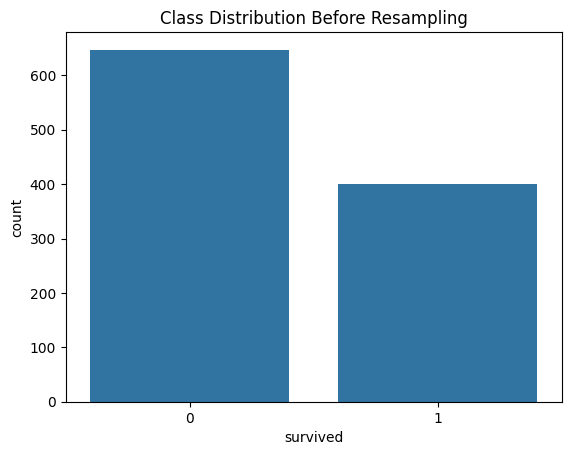

survived
0    647
1    400
Name: count, dtype: int64


In [1605]:
# visualize distribution before SMOTE
sns.countplot(x=y_train)
plt.title("Class Distribution Before Resampling")
plt.show()

# print class counts
print(y_train.value_counts())

In [1606]:
# drop non-numerical features before SMOTE
X_train = X_train.drop(columns=["name", "ticket"])
X_val = X_val.drop(columns=["name", "ticket"])
X_test = X_test.drop(columns=["name", "ticket"])

# now apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


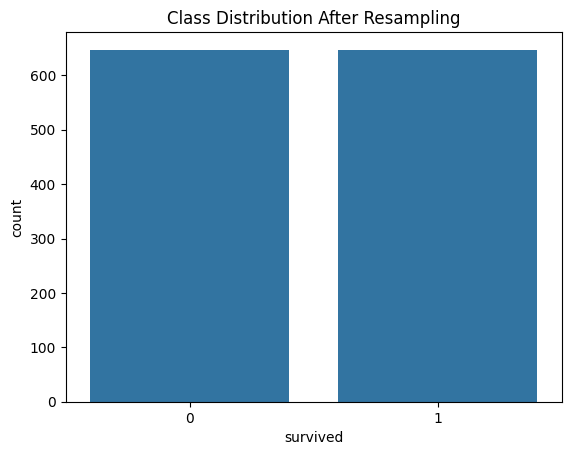

survived
1    647
0    647
Name: count, dtype: int64


In [1607]:
# visualize distribution after SMOTE
sns.countplot(x=y_train_smote)
plt.title("Class Distribution After Resampling")
plt.show()

# print class counts
print(y_train_smote.value_counts())

# Task 8: Feature selection

Selecting the most relevant features is very important to simplify the model and remove redundant features, leading to a more understandable and interpretable model. It also decreases the chance of overfitting.

There are a few methods available to select the most important features for the model:
1. Variance Threshold
The first method I tested was the variance threshold method, checking if any features have an extremely low variance (meaning they provide very little info to the model). I first checked the variance of each feature myself, to better understand what I am dealing with. Then, I set a threshold of 0.01 as a baseline for what is considered "too low". I chose this number as a general rule of thumb I found from researching. Additionally, due to the nature of the problem, I decided on a relatively lower threshold to not remove too many features that could carry important information. In my case, no features were removed, with all having a variance above the threshold. However, I noted that embarked_Q had the lowest variance (0.08).

2. Feature Correlation
The next method I used was removing highly correlated features, as high correlation implies redundancy since one feature predicts the other. Upon research, I came to understand: 
- very strong correlation from 0.80 to 1.00
- strong correlation from 0.60 to 0.80 
- moderate correlation from 0.40 to 0.60
- weak correlation from 0.20 to 0.40
- very weak correlation from 0.00 to 0.20

Comparing this with my correlation heatmap, many features are weakly correlated. However, a few features are moderately correlated:
- age and title
- embarked_Q and embarked_S
- pclass and fare. 
I decided to leave these features in, since they are only moderately correlated. However, I kept them in mind as potential features that could be removed if needed in the future. 
In terms of very strongly correlated features, both sibsp and parch are strongly correlated to family_size (0.82 for both). This meant that either sibsp and parch or family_size had to be dropped to reduce redundancy.

3. To make a more data driven decision, before dropping any features, I decided to conduct L1 regularization. Lasso regression (L1) helps remove irrelevant features, and it does this by shrinking some coefficients to 0, which effectively chooses the important features. I chose the parameter C=0.25, in an attempt to balance regularization strength but not be too aggressive and remove important features. Lasso removed:
- family_size
- embarked_Q

These results made sense, with both features under consideration for dropping earlier. Since family_size was removed, the high correlation with sibsp and parch is not an issue anymore, and although embarked had only a moderate correlation with embarked_S, it also had by far the lowest variance. 

In the end, the features Lasso kept nicely aligned with both the variance threshold and high correlation checks.

In [1608]:
# variance for each feature
feature_variances = X_train.var()
print("Feature Variances:")
print(feature_variances.sort_values(ascending=True))

Feature Variances:
embarked_Q     0.088783
embarked_S     0.211302
sex_male       0.229281
title          0.626061
pclass         0.691795
sibsp          1.000956
fare           1.000956
age            1.000956
parch          1.000956
family_size    2.434354
dtype: float64


In [1609]:
# variance threshold
threshold = 0.01

# low variance features
low_variance_features = feature_variances[feature_variances < threshold].index

# drop low variance features
X_train = X_train.drop(columns=low_variance_features)
X_val = X_val.drop(columns=low_variance_features)
X_test = X_test.drop(columns=low_variance_features)

print("Dropped low variance features:", low_variance_features.tolist())

Dropped low variance features: []


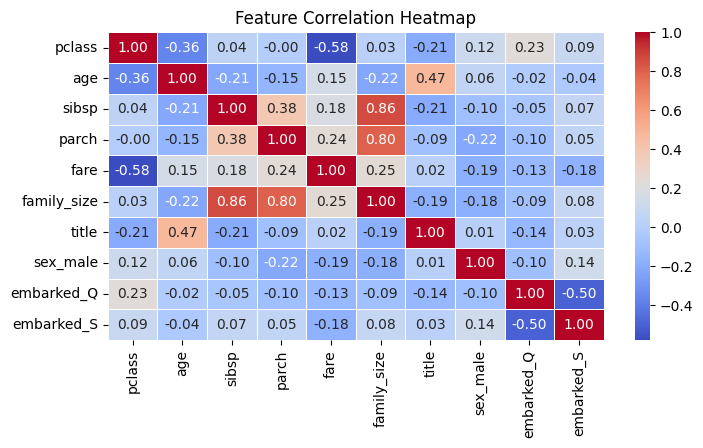

In [1610]:
# correlation matrix
corr_matrix = X_train.corr()

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [1611]:
# L1 regularization (Lasso)
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.25)  # C controls the strength
lasso.fit(X_train, y_train)

# get the coefficients
lasso_coefficients = pd.Series(lasso.coef_[0], index=X_train.columns)

# check which features Lasso kept
print("Features Lasso kept:")
print(lasso_coefficients[lasso_coefficients != 0])


Features Lasso kept:
pclass        -0.739427
age           -0.383545
sibsp         -0.272513
fare           0.140840
family_size    0.008694
sex_male      -2.242833
embarked_Q    -0.267127
embarked_S    -0.308618
dtype: float64


# Task 9: Training a Logisitic Regression Model

Finally, to wrap up this wonderful assignment that I learned so so much from, I trained a logistic regression model to predict survival. Logistic regression is commonly used for classification, and models the probability of an event occurring, so it fits our need for binary classification.

To make sure my results were as accurate as possible, I trained only on the training set and then made predictions based on the validation set. The validation set was specifically used to check model performance before testing on a final test set. To check performance I decided to use a confusion matrix as well as a classification report. The confusion matrix helped me visualize the correct and incorrect predictions, while the classification report provided some important metrics.

Some key results include:
- Accuracy: 82%. This means the model correctly classified 82% of passengers.
- Precision: 85% for non survivors, 79% for survivors
- Recall: 88% for non survivors, 74% for survivors
- F1-score: 86% for non survivors, 76% for survivors

The model is better at predicting non-survivors, with a higher recall (88% vs 74%). So it correctly identifies more passengers who did not survive, but misses some survivors. The model's overall accuracy (82%) suggests a fair enough balance between predicting survivors and non survivors. Future improvements (assignment 2!) could include hyperparameter tuning, or experimenting with different models to better performance.

     pclass       age     sibsp     parch      fare  family_size  title  \
351       2  2.388891  0.510785  0.712389  0.140175            3    2.0   
147       1 -0.099867 -0.479571 -0.447597  0.209744            1    2.0   
853       3 -0.333188 -0.479571 -0.447597 -0.509476            1    2.0   
349       2 -0.410961 -0.479571 -0.447597 -0.391823            1    1.0   
228       1 -0.877603  0.510785 -0.447597  1.570431            2    2.0   

     sex_male  embarked_Q  embarked_S  Predicted Survival  Actual Survival  
351       1.0         0.0         1.0                   0                0  
147       1.0         0.0         1.0                   0                0  
853       1.0         0.0         1.0                   0                0  
349       0.0         0.0         1.0                   1                1  
228       1.0         0.0         0.0                   1                0  


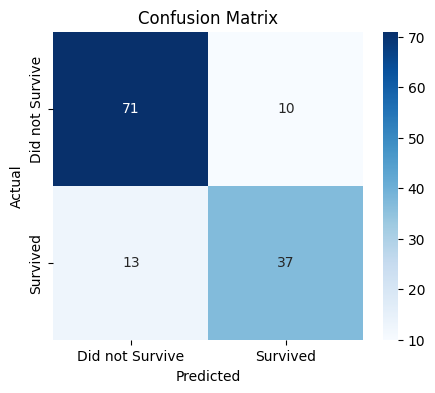

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        81
           1       0.79      0.74      0.76        50

    accuracy                           0.82       131
   macro avg       0.82      0.81      0.81       131
weighted avg       0.82      0.82      0.82       131



In [1613]:
# train the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# predict on the validation set
y_val_pred = logreg.predict(X_val)

# display predictions
val_results = X_val.copy()
val_results["Predicted Survival"] = y_val_pred
val_results["Actual Survival"] = y_val.values

# print first few predictions
print(val_results.head())

# confusion matrix visualization
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Did not Survive", "Survived"], yticklabels=["Did not Survive", "Survived"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# print classification report
print(classification_report(y_val, y_val_pred))